In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants.constants import C2K, K2C

from flow_stress.flow_stress import FlowStressCalculator#, plot_strain_slip_rates
#from flow_stress.grid import *


('Temperature: ', 100)
[400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]
('Pressure: ', 1)
[400]
('Fugacity: ', 100)
[86.11912549447844, 86.69906427970614, 87.28047461433566, 87.86334635835435, 88.447669350791, 89.03343341040475, 89.62062833636787, 90.20924390894317, 90.79926989016447, 91.39069602449433, 91.98351203949177, 92.5777076464713, 93.17327254115023, 93.77019640429798, 94.36846890237499, 94.96807968817346, 95.56901840144224, 96.1712746695145, 96.77483810792943, 97.37969832104169, 97.98584490263741, 98.59326743653214, 99.2019554971742,

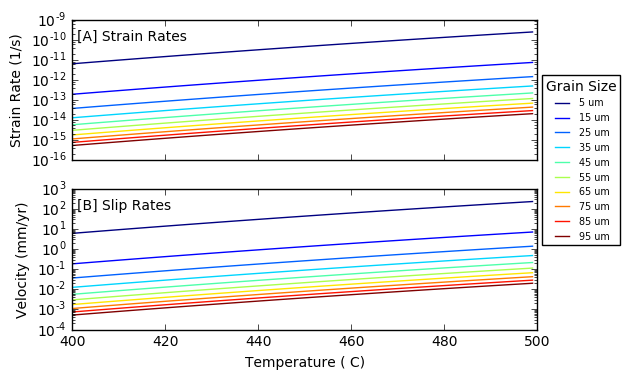

In [12]:
from flow_stress.flow_stress import *#FlowStressCalculator, plot_strain_slip_rates


temp = range(400,500)
pressure = [400]
grain_size = range(5,100, 10)#[10,12,13,16,27,29]##[5,6,7,8,9,10,11,12,13,14,15,30] #List of grainsizes 
width = [30]


f = FlowStressCalculator(temp,pressure)
fugacity = f.calculate_fugacity()
print('Temperature: ', len(temp))
print(temp)
print('Pressure: ', len([pressure]))
print(pressure)
print('Fugacity: ', len(fugacity))
print(fugacity)
print('Grain size: ', len(grain_size))

differential_stress = f.calculate_differential_stress(grain_size)#, paleopiezometer = 'T77')

strain_rate= f.calculate_strain_rate()
print('Strain rate: ', len(strain_rate))

slip_rate = f.calculate_slip_rate(width)
print('Slip rate: ', len(slip_rate))


#convert K back to C for plotting
#temperature_C = K2C(f.temperature)


plot_strain_slip_rates(f.temperature, strain_rate, slip_rate, grain_size)


In [12]:
from matplotlib.backends.backend_pdf import PdfPages
from flow_stress.flow_stress import export_pdf

# fig = plot_strain_slip_rates(f.temperature, strain_rate, slip_rate)
# fig.set_size_inches(9,6)
# export_pdf(fig, 'strain_slip_rates')

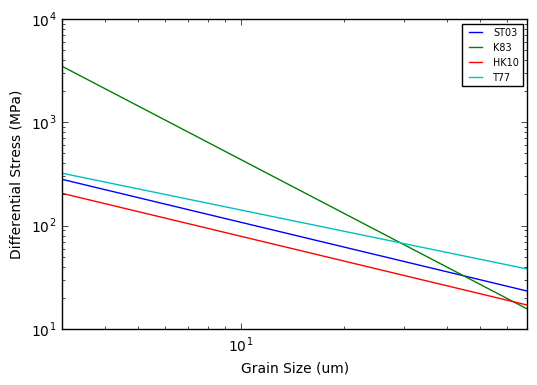

In [7]:
#plotting piezometers
import matplotlib.pyplot as plt
from flow_stress.flow_stress import PIEZOMETERS, FLOW_LAWS
temp = [450]
grain_size =range(3,70)
pressure = [400]

fig = plt.figure()
plt.yscale('log')
plt.xscale('log')

plt.xlabel('Grain Size (um)')
plt.ylabel('Differential Stress (MPa)')

for key in PIEZOMETERS:
    f = FlowStressCalculator(temp,pressure)
    f.calculate_fugacity()
    ds = f.calculate_differential_stress(grain_size, paleopiezometer = key)

    plt.plot(grain_size, ds, label=key)
    plt.xlim([min(grain_size),max(grain_size)])

    
plt.legend(loc='upper right', fontsize = 'x-small')
plt.show()

In [3]:
from flow_stress.pt_conditions import PTCalculator

In [36]:
depth = range(20,25)
density = 2.9
geothermal_gradient = 30
grain_size = range(2,70)


p, t= PTCalculator(depth, density, geothermal_gradient).pt_calculator()
print p
print t

[568.4000000000001, 596.8200000000002, 625.2400000000001, 653.6600000000001, 682.0800000000002]
[600, 630, 660, 690, 720]


In [9]:
#EXTRA STUFF, that might be of interest from other notebooks

#HOW TO, Share plot x axis
plt.setp(sub1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace = 0.001)

#HOW TO, iterate through linestyles
colors = iter(cm.gray(np.linspace(0, 1, len(v))))#set color ramp to jet with a line spacing of length e
lstyles=[':', '-.', '--', '-', ':', '-.', '--', '-',':' ]

#HOW TO, write a test without testtutils

s = 84

T = temp_conv(450)

x = np.power(s,4)
y = np.power(300,1)
z = np.exp(-135000/(8.3144598*T))
e = 6.3E-12*x*y*z
v = 30000*31536000*e

#how to write a test!
def test_calculate_slip_rate():
    w = 30000
    e = 2.043722042401592e-11
    slip_rate = calculate_slip_rate(e, w)
    assert slip_rate == 19.335245498752982
test_calculate_slip_rate()



NameError: name 'sub1' is not defined